# In this Lab exercise, you will use the time series imaging data from the TESS satellite to extract the light curve of an interesting target of your choice. This target can be a variable star, a transiting exoplanet system, a supernova transient, or an Active Galactic Nuclei. 

# prerequisites: 
## The main package used to manipulate TESS data
lightkurve: (https://docs.lightkurve.org/quickstart.html)
## Tool to locate where your target is in TESS data
tess-point (https://github.com/christopherburke/tess-point)
## Tool to access the TESS full-frame images
astroquery (https://astroquery.readthedocs.io/en/latest/)

## The first example is from the tutorial in the lightkurve package

In [1]:
from lightkurve import search_targetpixelfile
pixelfile = search_targetpixelfile("KIC 8462852", quarter=16).download();

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/yshen/.lightkurve/cache. Please move all the files in the legacy directory /Users/yshen/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


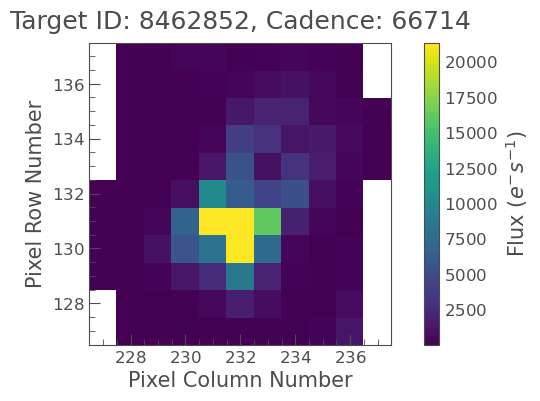

In [2]:
pixelfile.plot(frame=1);

In [3]:
lc = pixelfile.to_lightcurve(aperture_mask='all');

In [4]:
lc.time

<Time object: scale='tdb' format='bkjd' value=[1472.11777934 1472.13821223 1472.15864492 ... 1557.91762194 1557.9380561
 1557.95849016]>

In [5]:
lc.flux

<Quantity [258645.03, 258660.05, 258690.08, ..., 258948.84, 258884.66,
           258865.6 ] electron / s>

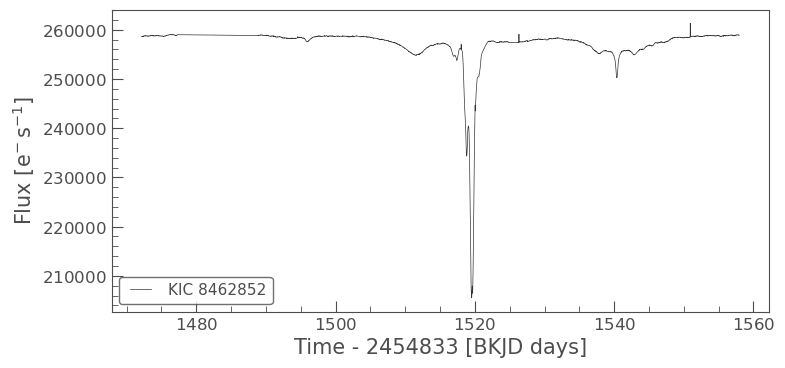

In [6]:
lc.plot();

# Now, let's look at a different target that is not in the pre-defined target database. 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astroquery.mast import Tesscut
from glob import glob
import lightkurve as lk
from astroquery.ned import Ned
from tess_stars2px import tess_stars2px_function_entry

<ipython-input-7-9a776156ac97>:9: DeprecationWarning: the ``ned`` module has been moved to astroquery.ipac.ned, please update your imports.
  from astroquery.ned import Ned


In [8]:
# first, we convert the coordinates for this blazar PKS 0521-365 into SkyCoord format
c = SkyCoord('05 22 57.9 -36 27 31', unit=(u.hourangle, u.deg))

In [9]:
# then, we use the functions in tess-point to figure out which TESS sector(s) this object is in. 
ra, dec = c.ra.degree, c.dec.degree
outID, outEclipLong, outEclipLat, outSec, outCam, outCcd, \
        outColPix, outRowPix, scinfo = tess_stars2px_function_entry(
                    9999, ra, dec)
for i in range(len(outID)):
        print('{0:d} {1:d} {2:d} {3:d} {4:f} {5:f}'.format(outID[i], outSec[i], \
          outCam[i], outCcd[i], outColPix[i], outRowPix[i]))

9999 5 3 1 1329.780941 1027.117097
9999 6 3 2 1530.154966 1165.656670
9999 32 3 1 1797.770892 979.226364


## There are three sectors available for this target (Sectors 5, 6 and 32). We only need to use the first sector (sector no=5)

## Now download the source target pixel file (TPF) file and load into lightkurve (be patient when it's downloading; sometimes the server has glitches and you may try again later)

In [10]:
sec_use = outSec[0]
cutout_size = [51, 51]
force_download = False
rastr, decstr = str("{0:.6f}".format(ra)), str("{0:.6f}".format(dec))
coord_str = rastr + '_' + decstr
fn = np.sort(glob('./*' + coord_str + '*.fits'))
if fn.shape[0] == 0 or force_download is True:
    coord = SkyCoord(ra, dec, unit="deg")
    manifest = Tesscut.download_cutouts(coordinates=coord, size=cutout_size, sector=sec_use)
fn = np.sort(glob('./*' + coord_str + '*.fits'))

In [11]:
# Check if we get the file downloaded in the current directory
fn

array(['./tess-s0005-3-1_80.741250_-36.458611_51x51_astrocut.fits'],
      dtype='<U57')

## Now let's look at the series of images

In [12]:
tpf = lk.read(fn[0])
ind_good = np.where(tpf.quality == 0)
tpf.shape

(1188, 51, 51)

<AxesSubplot:title={'center':'Target ID: None, Cadence: 100'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

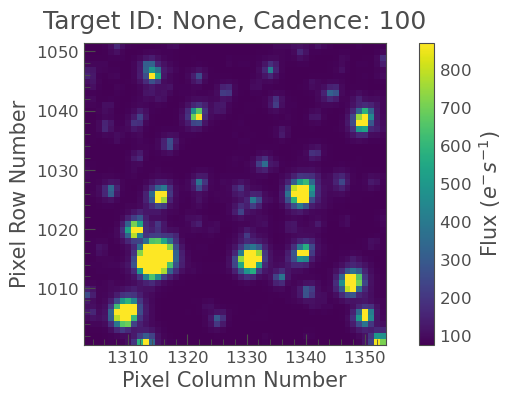

In [13]:
tpf.plot(frame=100)

## Define the apertures for the target, a comparison star, and the background

In [14]:
postage_stamp_mask = tpf.hdu[2].data < 0
postage_stamp_mask.sum()
targ_aper = postage_stamp_mask.copy()
bkg1_aper = postage_stamp_mask.copy()
star_aper = postage_stamp_mask.copy()
targ_aper[:,:] = False
star_aper[:,:] = False
bkg1_aper[:,:] = False

# you can define apertures for different stars
#star2_aper = star_aper.copy()
#star3_aper = star_aper.copy()
#star4_aper = star_aper.copy()

# This is a different way to get the background pixels
#iframe = 100
#bkg_aper = postage_stamp_mask.copy()
#bkg_aper[:,:] = False
#flux_sort = np.sort(tpf.flux[iframe,:,:],axis=None) 
#flux_thre = flux_sort[int(0.4*tpf.flux.shape[0])]  # default is the lowest 40% pixels
#ind = np.where(tpf.flux[iframe,:,:] < flux_thre)
#bkg_aper[ind] = True

targ_aper[25:28, 25:28] = True
star_aper[23:29, 34:40] = True # star to the immediate right
bkg1_aper[15:18,20:23] = True

N_targ_pix, N_star_pix, N_bkg1_pix = targ_aper.sum(), star_aper.sum(), bkg1_aper.sum()
N_targ_pix, N_star_pix, N_bkg1_pix

(9, 36, 9)

<AxesSubplot:title={'center':'Target ID: None, Cadence: 100'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

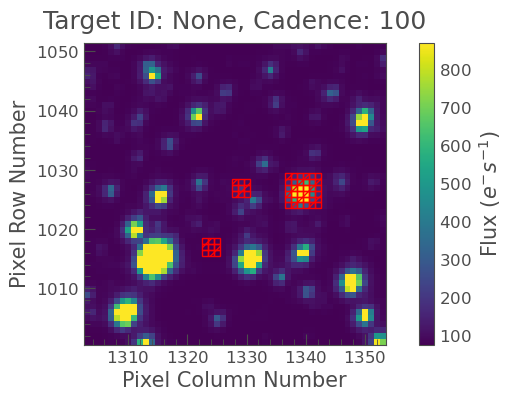

In [15]:
tpf.plot(frame=100,aperture_mask=targ_aper + star_aper + bkg1_aper)
#tpf.plot(frame=100,aperture_mask=star_aper)
#tpf.plot(frame=100,aperture_mask=bkg1_aper)

## now extract light curves

In [16]:
# estimate the background flux per pixel
lc_bkg = tpf.to_lightcurve(aperture_mask=bkg1_aper) / N_bkg1_pix

lc_targ = tpf.to_lightcurve(aperture_mask=targ_aper) - lc_bkg.flux * N_targ_pix
lc_star = tpf.to_lightcurve(aperture_mask=star_aper) - lc_bkg.flux * N_star_pix

In [17]:
# check if the fluxes for the target make sense
lc_targ.flux

<Quantity [450.24426, 450.365  , 453.30798, ..., 432.48926, 414.47852,
           420.64062] electron / s>

## make plots

Text(0.5, 1.0, 'PKS 0521-365 V=14.6')

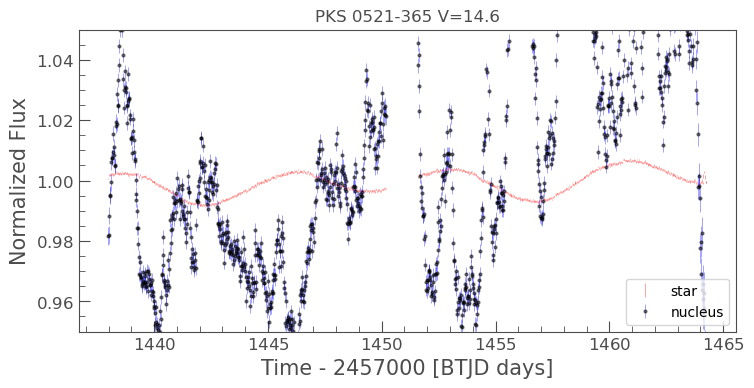

In [18]:
ax = lc_star.normalize().errorbar(color='red', alpha=0.5, label='star')
ax = lc_targ.normalize().errorbar(ax=ax, color='b', alpha=0.5, label='nucleus',marker='o',mfc='black',mec='black',ms=2)
plt.legend(loc='lower right')
plt.ylim(0.95,1.05)
plt.title('PKS 0521-365 V=14.6')

# Grading rules
## 1. You need to submit a pdf of your python notebook, with codes, descriptions, and plots. 
## 2. If you reproduce the example light curve in Tabby's star by following the tutorial provided in lightkurve, you get 50 points. You should always include this example in your report. 
## 3. To earn the remaining 100 points, you have to extract the light curve for a different object. This object can be a transiting planet, a variable star (e.g., a Cepheid), a transient (e.g., a supernova), an active galactic nuclei, or anything that shows a peculiar light curve. Targets that show roughly constant fluxes will not be considered valid target to earn the remaining points. 
## 4. In your report, you must provide why and how you chose this particular object, and what you learn from its light curve. (E.g., I chose a Cepheid variable from this catalog [give reference], and from the light curve I can estimate its period as ~5 days)
## 5. A light curve from a single TESS sector (~27 days) is fine, even though some targets are covered by more than one TESS sectors hence their light curves are longer. 
## 6. Your target should be unique. I don't expect the same target from more than one reports. Even if two reports chose the same target by accident, we don't expect the same exact apertures and descriptions in the reports, in which case neither report will receive the 100 points.   
## 7. This lab exercise is intended to provide you a taste of real astrometrical research, and it is possible to discover something new. More importantly, it provides training on problem-solving skills. Therefore, Sam and I will not provide further assistance other than this tutorial. You are basically on your own. 

# Finally, some useful tips to pick your target
## 1. Your target should be bright, with V mag or R mag brighter than 15. You should avoid crowded field where companion sources may comtaminate your target. Make sure your coordinates are correct and precise so that the target lies near the center of your cutout images and can be easily identified. 
## 2. When define your source aperture for light curve extraction, make sure you cover most of the pixels. The brighter your target is, the larger your aperture should be. Not including all the pixels of the star would lead to systematic jitter in the flux measurements from one frame to another. On the other hand, if your target has a brighter neighbor, try not to include flux from this neighbor (or switch target if necessry).  
## 3. Similarly, pay attention to your aperture for background estimation. These background pixels should not be affected by a bright nearby source. Otherwise, you would estimate the background incorrectly.
## 4. Finally, some useful catalogs to choose your targets from (but you don't have to use any of these if you have a different idea of targets, which is highly encouraged). 
### a. The nearby bright star list (use SIMBAD, i.e., check HW3)
### b. TESS-discovered planets: https://tess.mit.edu/publications/#list_of_tess_planets
### c. The all-sky blazar (a subclass of AGN that varies rapidly) catalog: https://heasarc.gsfc.nasa.gov/W3Browse/all/romabzcat.html

# Go find some weird objects !